<center><h1>Report of Project 3: "Implementation and evaluation of Otsu Thresholding"</h1></center>

*Elizaveta Chernova, Veronika Schuler, Laura Wächter, Hannah Winter*

<h3>Abstract</h3>
<div style="text-align: justify">
Thresholding is a useful method that is frequently used in the context of
image segmentation.
In this project, we used Otsu's thresholding algorithm in order to find the optimal threshold value,
that optimizes the image segmentation.
This algorithm will be applied to a number of pictures from different datasets.
To improve the results, several preprocessing methods (mainly filters) are used.
The final segmentation is compared to the ground truth and evaluated with several methods.
The datasets are characterized by different features, like reflections or low contrast.
For this reason, it is likely that different preprocessing methods will lead to the optimal result.
Our overall analysis confirms this hypothesis.
</div>

<h3>Table of contents</h3>

...

<h3>Introduction</h3>
<div style="text-align: justify">
In computer vision, image segmentation is used for a variety of purposes. In general, image segmentation describes the process of dividing a digital image into multiple segments
 to simplify the image. These simplified images can be used for further analyses. In the field of medicine or biology,
image segmentation is often used to locate tumors and other pathologies or to measure tissue volume.
Segmentations of images displaying cell nuclei are often used as an input for
algorithms that measure the number or size of the cell nuclei. If time-laps images are used,
it is also possible to track the cell movement.
<br>
Thresholding is a simple method of image segmentation. Based on a single intensity value, the image is divided into two segments:
 Pixels with with higher intensities and pixels with lower intensities than the threhold value are distinguished.
 In order to find the threshold value, that results in the best possible image segmentation we use 'Otsu's Thredholding' algorithm.
<br>
In the course of the project, we will work with three different data sets,
 each of which will present us with different challenges:
 Low contrast, noise and reflections make it difficult to distinguish the cells and the background.
 In order to achieve good results despite these difficulties, different preprocessing methods are applied to the images prior to the image segmentation.
 Due to the differences between the datasets we hypothesize that different preprocessing methods will result in the optimal segmentation for every dataset.
<br>
The accuracy of the obtained segmented image is evaluated by using the dice score as well as the median surface distance
and the Hausdorff distance. These metrics compare the obtained segmentation to the hand-segmented ground truth image.
Beyond that, we implemented a cell counting algorithm to give a meaning to the segmented images.
</div>


<h3>Description of the datasets</h3>

*N2DH-GOWT1 cells*

The dataset N2DH-GOWT1 of the cell tracking challenge (Bártová et al., 2011) contains images of GFP-GOWT1 mouse
embryonic stem cells that have been derived with time-lapse confocal microscopy with a Leica TCS SP5 microscope.
The varying brightness of the cells makes it hard to distinguish all the cells from the background.

*N2HL-HeLa cells*

The dataset N2DL-HeLa of the cell tracking challenge (Neumann et al., 2010) contains images of human epithelial cells
of cervical cancer. Those images have been derived with an Olympus IX81 microscope used for live imaging of
fluorescently labelled chromosomes. The challenge in these images is the variety of brightness of the cells.

*NIH3T3 cells*

The dataset NIH3T3 (Coelho et al., 2009) contains images of several mouse embryonic fibroblast cells. These images
have also been derived with fluorescence microscopy images and the difficulty in segmenting these images mainly
lies in the bright light spots, probably from the used microscope, that makes it difficult for the algorithm to choose
a threshold between the brightness of the cells and the background and not between the brightness of light spots
and the cells.




In [25]:
# Import of the Modules
import numpy as np
from skimage.io import imread
from skimage.io import imshow
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from nuclei_segmentation import otsu
from nuclei_segmentation import evaluation
from nuclei_segmentation import visualisation
from nuclei_segmentation import metrics, complete_analysis
import pathlib as pl
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

**Loading images, Preprocessing, Otsu, Evaluation of usage on datasets, Discussion**

In order to receive the best possible segmentation, different preprocessing methods are applied to the images from the different datasets.
The following approaches were made: Initially, we implemented the Gauss and Median filter, as well as histogram stretching individually.
After that, we applied a combination of histogram stretching and one of the filters.

**Preprocessing**

*Gauss filter*
<br>
The Gaussian filter is a filter mask that multiplies the values of the neighboring pixels with values according to the
gaussian distribution with standard deviation $\sigma$. This function is used in order to
reduce the noise in the images.

\begin{align*}
G_σ(x,y) = \frac{1}{σ^2 2π}  e^\frac {-(x^2 + y^2)}{2σ^2} \\
\end{align*}


*Median filter*
<br>
The median filter is a useful tool to tackle salt-and-pepper noise in the images. It takes the median intensity of the
central pixel and the surrounding pixels in the neigborhood by weighting each pixel the same.

*Histogram stretching*
<br>
To solve the problem of low contrast images, we decided to use histogram stretching.
To do that, the minimum and the maximum intensity values of the original image are taken and remapped to 0 or 1
respectively. All the values in-between are recalculated based on a linear function.

\begin{align*}
P_{out} = (P_{in} - c) \frac{(b-a)}{(d-c)} + a
\end{align*}

<br>

<center>
a = Minimal intensity of the input image
<br>
b = Maximal intensity of the input image
<br>
c = Minimal intensity in the output image
<br>
d = Maximal intensity in the otput image

</center>

<br>


**Otsu's Thresholding**

The next step after preprocessing our pictures is to implement our image segmentation algortihm with help of Otsu's
thresholding.
The Otsu algorithm is utilized to select the perfect threshold if the distribution is not bimodal by testing all possible
threshold values k.
The algorithm returns a single intensity threshold that separates all pixels into two classes – foreground and
background. For the algorithm, only the gray value histogram of the image is needed.

By using the mean intensity value (µ) as well as the probability of class occurrence of each class, the algorithm
computes the in-between-class-variance for all of the possible threshold values k by searching for the value k
that maximizes the between-class-variance. This value will be our optimal threshold.


Between-class-variance:

\begin{align*}
    σ_B = ω_0ω_1(µ_1 - µ_0)^2
\end{align*}

\begin{align*}
σ = standard deviation
\end{align*}

\begin{align*}
    ω_{0,1} = probability \enspace of \enspace class \enspace occurrence
\end{align*}


\begin{align*}
    µ_{0,1} = mean \enspace intensity \enspace values
\end{align*}

Finally, we assign the intensity value 0 to all pixels having a lower or equal value than the computed optimal threshold
value. Likewise, we assign the intensity value 255 to all pixels having a higher intensity value than the computed
threshold.

\begin{align*}
     g_{clip} (x,y)=\left\{\begin{array}{ll}0 & if & g(x,y) <= k  \\
     255 & if & g(x,y) > k\end{array}\right. .
\end{align*}

Now we have received our binary image.

*Two-level Otsu*

Two-level Otsu basically works like the normal Otsu's algorithm, but instead of computing only one threshold,
it gives out two thresholds that separate the pixels into two classes. This method is very useful to separate light
reflections from the cells and don't count them as foreground.


\begin{align*}
σ_B^2 = ω_1(µ_1 - µ_T)^2 + ω_2(µ_1 - µ_T)^2
\end{align*}

\begin{align*}
σ = standard deviation
\end{align*}

\begin{align*}
    ω_{1,2} = probability \enspace of \enspace class \enspace occurrence
\end{align*}


\begin{align*}
    µ_{1,2} = mean \enspace intensity \enspace values
\end{align*}



**Evaluation methods**

*Dice Score (DSC)*

In this method we have a look at the overlapping area of the prediction and of the ground truth, compared to the total
area of the prediction and the total are of the ground truth.
Put in a formula:


\begin{align*}
    DSC = \frac{2*|A ∩ B|}{|A| + |B|} \\
\end{align*}

\begin{align*}
A = GT
\end{align*}

\begin{align*}
B = segmented \enspace image
\end{align*}

The value of the dice score measures how successful our cell nuclei segmentation was.The best score you can obtain is
1 and the worst is 0.

*Mean Surface Distance (MSD)*

This method also evaluates how well our image segmentation, with the help of Otsu's thresholding, was performed on the
given images.
Thereby it measures the distance of the border of the segmented cell nuclei to the border of the ground truth nuclei.
It computes the mean distance of all the calculated values.
The formula used is depicted here:

\begin{align*}
    d(p, S') = min ||p - p'||_2; \enspace p' ∈ S'
\end{align*}

\begin{align*}
    MSD = \frac{1}{n_s + n_s'}  \\ (\sum_{p=1}^{n_s} d(p,S') + \sum_{p'=1}^{n_s'}  d(p',S))
\end{align*}

\begin{align*}
    d = \enspace distance
\end{align*}

\begin{align*}
     S \enspace and \enspace S′= outer \enspace surfaces
\end{align*}

\begin{align*}
p = point \enspace on \enspace surface \enspace S \enspace and \enspace the \enspace surface \enspace S′
\end{align*}


*Hausdorff method*

The Hausdorff method is very similar to MSD, the only difference is that it computes the maximum distance of all values.
Thus, the formula must be:

\begin{align*}
    HD = max[d(S,S'), \enspace d(S',S)]
\end{align*}

\begin{align*}
    d = \enspace distance
\end{align*}

\begin{align*}
     S \enspace and \enspace S′= outer \enspace surfaces
\end{align*}

**Cell counting**
<br>
The basic idea of the cell counting algorithm is to identify all pixels that form the outline of the segmented cells.
 These ‘border pixels’ are located by identifying intensity changes from zero to one in the segmented image.
 By grouping adjacent border pixels, all pixels belonging to the same shape are combined into groups.
 The count of the obtained groups matches the count of cells in the image.


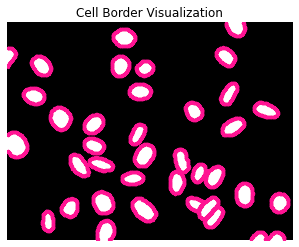

In [26]:
cell_counting_example = imread(str(pl.Path('./Data/NIH3T3/gt/42.png')))
border_pixels = metrics.find_border(cell_counting_example)
visualisation.border_image(cell_counting_example, border_pixels);

In [72]:
# Set to True if one level recalculations are desired (requires a few hours...)
recalculate_one_level = False

result_json_path_one_level = pl.Path("Results/values.json")
if recalculate_one_level or not result_json_path_one_level.exists():
    data = complete_analysis.one_level_complete_calculation()
    with open(result_json_path_one_level) as file:
        file.write(data)         
else:
    with open(str(result_json_path_one_level), "r") as file:
        data_one_level = json.load(file)
        
# Set to True if two level recalculations are desired (requires a few hours...)
recalculate_two_level = False

result_json_path_two_level = pl.Path("Results/two_lvl.json")
if recalculate_two_level or not result_json_path_two_level.exists():
    data = complete_analysis.two_level_complete_calculation()
    with open(result_json_path_two_level) as file:
        file.write(data)         
else:
    with open(str(result_json_path_two_level), "r") as file:
        data_two_level = json.load(file)

**Dataset 1**

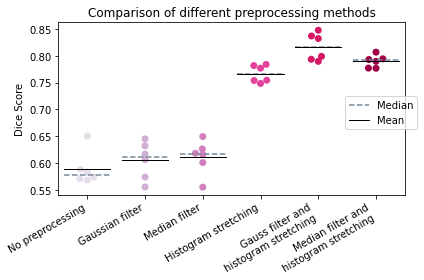

In [84]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "N2DH-GOWT1"))

Results:

After applying all sorts of pre-processing methods, the highest dice score, with 81.7 %, was obtained when
using the median filter and histogram stretching. Also here all sorts of pre-processing methods were used. Finally, the best median surface distance value was obtained
when using only histogram stretching. The derived value is 2.282.

Discussion

The images in this dataset were very low in contrast which made it hard to distinguish the all cell nuclei from
the background.
To solve this particular problem we decided to use histogram stretching. In order to do that, the minimum and
the maximum intensity values of the original image are taken and remapped to 0 or 1. All the values in between are
recalculated based on a linear function. After that, the median filter was implemented. The median takes the median
intensity of the central pixel and the surrounding pixels in the neighborhood by weighing each pixel the same.
As described above, histogram stretching increases the contrast of the cell nuclei images.


**Dataset 2**

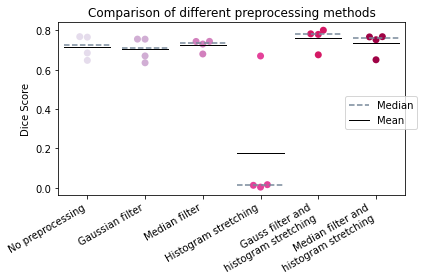

In [81]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "N2DL-HeLa"))

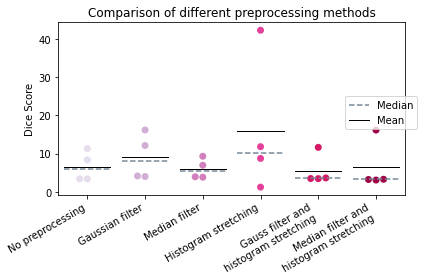

In [82]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_msd(data_one_level, dataset = "N2DL-HeLa"))

Results

We used all kinds of combinations of pre-processing functions on N2DL-HeLa cells. The dice score tells that a combination
out of median filter and histogram stretching works best, with a mean value of 76 percent correctness. The mean value
of all mean surface distance values is 5.527, which is quite low compared to the msd values of other datasets and
confirms this pre-processing combination. Only the hausdorff value is 119,439 which is also good compared to other
datasets but suggests a different pre-processing method to be the best choice for this kind of picture: the gaussian
filter.

Discussion

The challenge in images of N2DL- HeLa cells is the strongly varying brightness. The median filter makes the image look
smoother and the histogram stretching makes the contrast between foreground and background stronger. Therefore, the
histogram of intensity levels has a deeper and sharper valley and it will be easier for Otsu’s algorithm to find the
correct threshold. It does make sense to choose those pre-processing methods. There is only a correctness of 76 percent,
because there are still cells with very low intensity values that are excluded as background and therefore deviate from
the ground truth images.



**Dataset 3**
<br>
Results

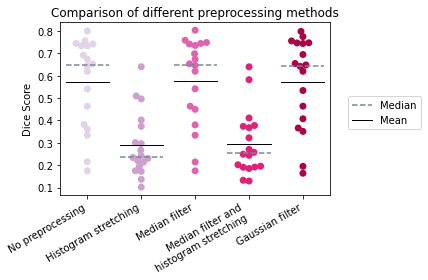

In [86]:
scores = complete_analysis.get_all_two_level_results(str(pl.Path("Results/two_lvl.json")), "NIH3T3")
visualisation.comparison_swarmplot(scores,
                                 x_label=["No preprocessing", "Histogram stretching","Median filter",
                                          "Median filter and\nhistogram stretching", "Gaussian filter"])

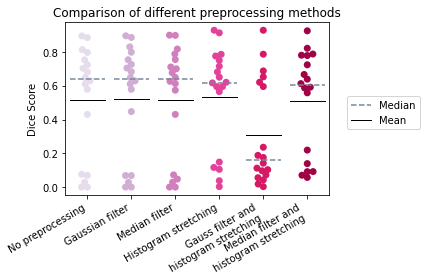

In [79]:
visualisation.comparison_swarmplot(complete_analysis.get_one_lvl_dice_scores(data_one_level, dataset = "NIH3T3"))

Diskussion

## Cell nuclei counting

### Results

The cell nuclei counting algorithm was tested on the ground truth images from N2DH-GOWT1 and N2DL-HeLa datasets. The single cell nuclei in the ground truth images in these datasets have different intensities. Therefore it is possible to extract the ground truth number of cell nuclei from the images.

The results are presented in the following tables.

In [ ]:
with open(str(pl.Path('Results/cell_counting_results.json')), "r") as file:
    cell_counting_results = json.load(file)
    
table_GOWT1 = pd.DataFrame.from_dict(cell_counting_results["N2DH-GOWT1"])
table_GOWT1 = table_GOWT1.set_axis(["man_seg01.tif", "man_seg21.tif", "man_seg31.tif", 
                                    "man_seg39.tif", "man_seg52.tif", "man_seg72.tif"], axis = 0)
table_GOWT1.style.set_caption('Table 1: Results of the cell counting on the N2DH-GOWT1 dataset.')

In [ ]:
table_HeLa = pd.DataFrame.from_dict(cell_counting_results["N2DL-HeLa"])
table_HeLa = table_HeLa.set_axis(["man_seg13.tif", "man_seg52.tif", "man_seg75.tif", "man_seg79.tif"], axis = 0)
table_HeLa.style.set_caption('Table 2: Results of the cell counting on the N2DL-HeLa dataset.')

In [ ]:
mean_error = np.abs(np.mean(cell_counting_results["N2DL-HeLa"]["Relative difference"] 
                            + cell_counting_results["N2DH-GOWT1"]["Relative difference"]))
standard_deviation =np.abs(np.std(cell_counting_results["N2DL-HeLa"]["Relative difference"] 
                                  + cell_counting_results["N2DH-GOWT1"]["Relative difference"]))
print("Relative error (datasets combined): {} +/- {}".format(mean_error, standard_deviation))

### Discussion

Our algorithm could correctly calculate the cell nuclei number in only 2 of 10 images. The relative error did not exceed 10% and 5% when applied to the N2DH-GOWT1 and on the N2DL-HeLa datasets respectivly. By analyzing the images we determined the possible causes of the errors. Characteristic examples are shown below.

In [ ]:
img_GOWT1 = imread(str(pl.Path('Data/N2DH-GOWT1/gt/man_seg21.tif')))
img_HeLa = imread(str(pl.Path('Data/N2DL-HeLa/gt/man_seg75.tif')))

visualisation.two_img_plot(img_GOWT1[660:800, 800:940], img_HeLa[610:660, 1020:1070], 
                           "A. Section of man_seg21.tif\n   (N2DH-GOWT1)", 
                           "B. Section of man_seg75.tif\n   (N2DH-HeLa)")

Some images contain touching cell nuclei as shown in the figure A. The two cell nuclei have a common border in this case, therefore our algorithm detects only one cell.

In other cases there are small black regions inside the cell nuclei, as shown in the following figure B. In this case our algorithm would detect not only the border around the cell, but also the border around the black pixel inside the cell. Since these two borders do not touch, they would be assigned to two different groups and therefore counted as two cell nuclei.

**Conclusion**


Hausdorff is not suitable since our segmentation methods are too imprecise and we therefore always receive very random
values which are sometimes very high. Hausdorff takes the maximum surface-distance and it is therefore logical that
the values turn out to be very high. However, we are of the opinion that Hausdorff is not really of use to us which is
the reason why we are not applying this evaluation method.

The values of the DSC and MSC differ greatly as both values explain how well the segmentation was performed in two
different kind of ways. The DSC focuses on the overlap of the GT and the segmented image. The larger the area of
overlap is, the higher the DSC will be.
However, the MSD calculates the distance between the edges of the cells. The greater the distance,
the greater the MSD, which implies that the segmentation is performed well. Vice versa, the smaller the MSD,
the better the segmentation.

The median filter does work better than the gaussian filter, because there is more salt-and-pepper noise in the cell
nuclei images than there is gaussian noise.